In [1]:
%pylab inline
import cvxpy as cvx

# logs - export only the logger
import logging
reload(logging) #for iPython interactive usage
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

Populating the interactive namespace from numpy and matplotlib


#### Helper functions 

In [2]:
def simulate_trajectories(sampled_returns, b):
    """Simulate log-wealth trajectories."""
    N_SAMPLES, T, n = sampled_returns.shape
    return np.hstack([np.zeros((N_SAMPLES, 1)),
                      np.cumsum(log(np.dot(sampled_returns, b)), axis=1)])

def growth_rate_Wmins(logw_samples):
    """Simulate expected log growth rate and samples W_min."""
    T = logw_samples.shape[1] - 1
    return mean(logw_samples[:,-1])/T, exp(np.min(logw_samples, axis=1))

def drawdown_prob(W_mins, alpha):
    return sum(W_mins < alpha)/float(len(W_mins))

def empirical_cdf(samples, grid):
    return array([sum(samples <= el) for el in grid], dtype=float) / len(samples)

# Definitions

### Constants 

In [3]:
n = 20 # number of assets, including risk-free 

# generate returns
np.random.seed(0)
mean_return1 = .05 #1.25
mean_return2 = -.1 # 0.85
sigma_idyo = .05
sigma_fact = .30 #.2 
NFACT = 5 #5

factors_1 = matrix(np.random.uniform(size=(n,NFACT)))
Sigma1 = diag([sigma_idyo**2]*n) + factors_1*diag([sigma_fact**2]*NFACT)*factors_1.T
Sigma1[:,-1] = 0
Sigma1[-1,:] = 0

factors_2 = matrix(np.random.uniform(size=(n,NFACT)))
Sigma2 = diag([sigma_idyo**2]*n) + factors_2*diag([sigma_fact**2]*NFACT)*factors_2.T
Sigma2 *= 5
Sigma2[:,-1] = 0
Sigma2[-1,:] = 0

mu1 = np.concatenate([mean_return1 + np.random.randn(n-1)*mean_return1/3., [0.]])
mu2 = np.concatenate([mean_return2 + np.random.randn(n-1)*mean_return2/3., [0.]])

prob1 = .5
prob2 = .5

# draw batch returns
def draw_batch_returns(N_DRAWS):
    result = np.vstack([
            exp(np.random.multivariate_normal(mu1, Sigma1, size = int(N_DRAWS * prob1))),
            exp(np.random.multivariate_normal(mu2, Sigma2, size = int(N_DRAWS * prob2)))
        ])
    np.random.shuffle(result)
    return result

MC_N_SAMPLES = 10000
MC_T = 100
N_ITER = 1000000
batch_size = 100

np.random.seed(10)
learning_sample = draw_batch_returns(N_ITER)

monte_carlo_sample = draw_batch_returns(MC_N_SAMPLES*MC_T)
monte_carlo_sample_plain = np.array(monte_carlo_sample)
monte_carlo_sample = monte_carlo_sample.reshape((MC_N_SAMPLES, MC_T, n))

# risk constraint
alpha = .7
beta = .1

SAVE_FIGURES = True

In [5]:
def simplex_project(vector):#, precision = 1E-9):
    vector = np.array(vector)
    low = np.max(vector) - 1
    high = np.max(vector)
    while np.sum(vector < low) < np.sum(vector < high):
        probe = (low + high)/2.
        result = np.maximum(vector - probe, 0)
        if np.sum(result) > 1:
            low = probe
        else:
            high = probe
    lambda_var = (np.sum(vector[vector >= high]) - 1.) / np.sum(vector >= high)
    return np.maximum(vector - lambda_var, 0)

def stoch_mir_approx_kelly(learn_rets, lambda_risk, b_1, kappa_1, M = 1., 
                           C = 0.01, averaging = True, batch = 1):

    N_SAMPLES, n = learn_rets.shape
    N_ITER = int(N_SAMPLES/batch)
    
    bs = np.zeros((n,N_ITER+1))
    kappas = np.zeros(N_ITER+1)
    ts = C*np.arange(1, N_ITER+2)**(-.5)
    
    b_k = b_1
    kappa_k = kappa_1
    
    bs[:,0] = b_1
    kappas[0] = kappa_1
    
    for k in range(N_ITER):
        r_k = learn_rets[k*batch:(k+1)*batch,:]
        
        kappa_k_old = float(kappa_k)
        b_k_old = np.array(b_k)

        g_k = mean(- np.divide(r_k.T, np.dot(r_k,b_k)) - \
                   kappa_k_old * lambda_risk * np.multiply(r_k.T, np.dot(r_k,b_k)**(-lambda_risk-1)), 1)
        b_k = b_k - ts[k-1] * g_k 
        
        h_k = mean(np.dot(r_k, b_k_old)**(-lambda_risk) - 1, 0)
        kappa_k = kappa_k + ts[k-1] * h_k

        b_k = simplex_project(b_k)
        kappa_k = max(min(kappa_k, M), 0) 

        bs[:,k+1] = b_k
        kappas[k+1] = kappa_k
        
    if averaging:
        return np.cumsum(bs[:,:] * ts, axis=1)/np.cumsum(ts), np.cumsum(kappas[:] * ts)/np.cumsum(ts)   
    else:
        return bs, kappas

### Define QRCK 

In [6]:
rhos = matrix(learning_sample.T-1)
mu = mean(rhos, 1)
second_moment = np.cov(rhos) + mu * mu.T
    
b_qrck = cvx.Variable(n)
lambda_qrck = cvx.Parameter(sign='positive')
growth = b_qrck.T*mu
variance = cvx.quad_form(b_qrck, second_moment)
risk_constraint_qrck = lambda_qrck*(lambda_qrck + 1) * variance/2. <= lambda_qrck*growth
constraints = [cvx.sum_entries(b_qrck) == 1, b_qrck >= 0, risk_constraint_qrck] 
probl_qrck = cvx.Problem(cvx.Maximize(growth - variance/2.), constraints)

# Comparison of RCK and Kelly bets 

### Table 

In [7]:
print "lambd\tgr_MC\tprob_th\tprob_MC"
cached_bets_rck = {}
for lambda_risk in [0, log(beta)/log(alpha), 5.7]:
    print '%.3f '% lambda_risk,
    C = 1. / (1 + lambda_risk)
    lambda_qrck.value = lambda_risk
    probl_qrck.solve()
    b_1 = b_qrck.value.A1
    kappa_1 = risk_constraint_qrck.dual_value
    bs, kappas = stoch_mir_approx_kelly(learning_sample, lambda_risk, b_1, kappa_1, M = kappa_1 * 20., 
                                           C = C, averaging = True, batch = batch_size)
    cached_bets_rck[lambda_risk] = bs[:, -1]
    exp_growth_rate, W_mins = growth_rate_Wmins(simulate_trajectories(monte_carlo_sample, 
                                                                      cached_bets_rck[lambda_risk]))
    print '& %.3f '% (exp_growth_rate),
    print '& %.3f '% (exp(lambda_risk * log(alpha))),
    print '& %.3f \\\\'% drawdown_prob(W_mins, alpha)

lambd	gr_MC	prob_th	prob_MC
0.000  & 0.077  & 1.000  & 0.569 \\
6.456  & 0.039  & 0.100  & 0.080 \\
5.700  & 0.043  & 0.131  & 0.101 \\


### Wealth trajectories 

trajectories with W_min < alpha: 6 of 10
trajectories with W_min < alpha: 1 of 10


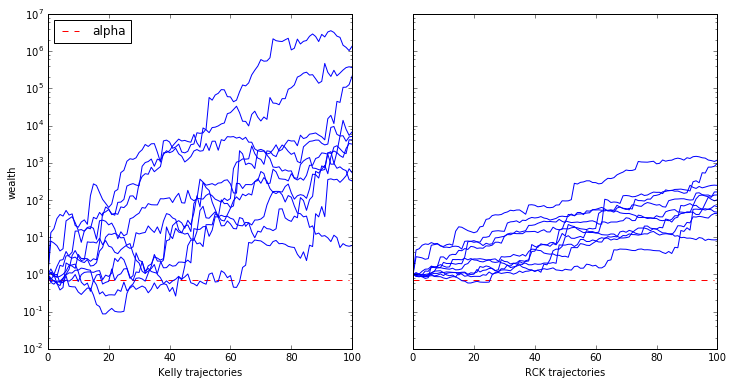

In [10]:
N_TRAJ = 10
lambda_star = 5.7
OFFSET = 2

figure(figsize(12,6))
f, (ax1, ax2) = subplots(1, 2, sharey=True)
ax1.semilogy(arange(MC_T), [alpha]*MC_T, 'r--', label = 'alpha')
ax2.semilogy(arange(MC_T), [alpha]*MC_T, 'r--', label = 'alpha')
ax1.set_xlabel("Kelly trajectories")
ax2.set_xlabel("RCK trajectories")
ax1.set_ylabel("wealth")
ax1.legend(loc='upper left')

for ax, lambda_risk in zip([ax1, ax2], [0., lambda_star]):
    logw_samples = simulate_trajectories(monte_carlo_sample, cached_bets_rck[lambda_risk])
    logw_samples = logw_samples[OFFSET:OFFSET+N_TRAJ, :]
    
    print "trajectories with W_min < alpha: %d of %d" %\
        (sum(exp(np.min(logw_samples,axis=1)) < alpha), N_TRAJ)
        
    for i in range(N_TRAJ): 
        wealth = exp(logw_samples[i,:])
        ax.semilogy(wealth, 'b') 

if SAVE_FIGURES:
    savefig('wealth_trajectories_infinite.png')

### Sample CDF of Wmin 

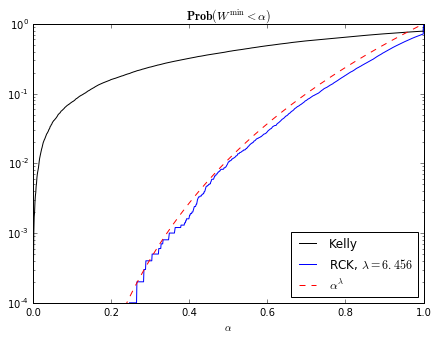

In [11]:
W_min_samples = []

for lambda_risk in [0, log(beta)/log(alpha)]:
    exp_growth_rate, W_mins = growth_rate_Wmins(simulate_trajectories(monte_carlo_sample, 
                                                                      cached_bets_rck[lambda_risk]))
    W_min_samples.append(W_mins)

step = 0.001
x = np.arange(0,1+step,step)

figure(figsize=(7,5))
semilogy(x, empirical_cdf(W_min_samples[0], x), 'k', label='Kelly')
semilogy(x, empirical_cdf(W_min_samples[1], x), 'b', 
         label='RCK, $\lambda = %.3f$'%(log(beta)/log(alpha)))

_ = ylim()
semilogy(x, x**(log(beta)/log(alpha)), 'r--',label = '$\\alpha^\lambda$')
ylim(_)
title('$\mathbf{Prob}(W^{\mathrm{min}} < \\alpha )$')
xlabel('$\\alpha$')
legend(loc='lower right')

if SAVE_FIGURES:
    savefig('sample_cdf_wmin_infinite.png')

# Risk-growth trade-off of RCK, QRCK, and fractional Kelly bets 

2016-03-18 00:24:39,653 - INFO - solving (Q)RCK lambda = 0.00
2016-03-18 00:24:55,099 - INFO - solving (Q)RCK lambda = 1.26
2016-03-18 00:25:08,188 - INFO - solving (Q)RCK lambda = 2.15
2016-03-18 00:25:21,318 - INFO - solving (Q)RCK lambda = 3.69
2016-03-18 00:25:35,204 - INFO - solving (Q)RCK lambda = 6.31
2016-03-18 00:26:01,036 - INFO - solving (Q)RCK lambda = 10.80
2016-03-18 00:26:16,306 - INFO - solving (Q)RCK lambda = 18.48
2016-03-18 00:26:30,023 - INFO - solving (Q)RCK lambda = 31.62


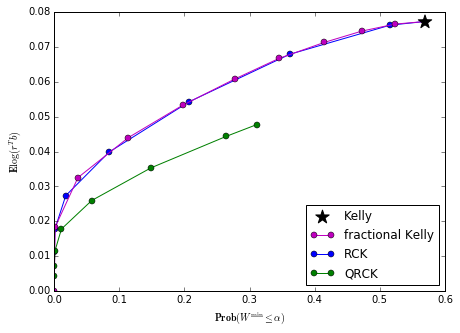

In [12]:
# obtain fractional bets
num_frac_bets = 11
risk_free_bet = array([0.]*(n-1) + [1.])
fractional_bets = [f * cached_bets_rck[0.] + (1-f) * risk_free_bet
                  for f in np.linspace(0, 1, num = num_frac_bets, endpoint=True)]

result_MC_frac = [growth_rate_Wmins(simulate_trajectories(monte_carlo_sample, b_frac)) 
                  for b_frac in fractional_bets]

# RCK and QRCK
result_MC_RCK = []
result_MC_QRCK = []
lambdas_risk = np.concatenate([[0.], np.logspace(.1,1.5,7)])

for lambda_risk in lambdas_risk:
    logger.info('solving (Q)RCK lambda = %.2f'%lambda_risk)
    C = 1. / (1 + lambda_risk)
    
    # qrck
    lambda_qrck.value = lambda_risk
    probl_qrck.solve()
    result_MC_QRCK.append(growth_rate_Wmins(simulate_trajectories(monte_carlo_sample, 
                                                                  b_qrck.value.A1)))
    
    b_1 = b_qrck.value.A1
    kappa_1 = risk_constraint_qrck.dual_value
    bs, kappas = stoch_mir_approx_kelly(learning_sample, lambda_risk, b_1, kappa_1, 
                                                  M = kappa_1 * 20., C = C, 
                                                  averaging = True, batch = batch_size)
    result_MC_RCK.append(growth_rate_Wmins(simulate_trajectories(monte_carlo_sample, 
                                                                 bs[:,-1])))

# plot
figure(figsize=(7,5))
l1 = plot(array([drawdown_prob(el[1], alpha) for el in result_MC_RCK]), 
      [el[0] for el in result_MC_RCK], 'b-o', label='RCK', zorder=1)
l2 = plot(array([drawdown_prob(el[1], alpha) for el in result_MC_frac]), 
      [el[0] for el in result_MC_frac], 'm-o', label='fractional Kelly', zorder=1)
l3 = plot(array([drawdown_prob(el[1], alpha) for el in result_MC_QRCK]), 
      [el[0] for el in result_MC_QRCK], 'g-o', label='QRCK', zorder=1)
xl = xlim()
yl = ylim()
s1 = scatter(drawdown_prob(result_MC_RCK[0][1], alpha),
     result_MC_RCK[0][0], color='k', marker='*', s=200, label='Kelly', zorder=2)
lines = [s1, l2[0], l1[0], l3[0]]
legend(lines, [el.get_label() for el in lines], loc='lower right',  scatterpoints=1)
xlabel('$\mathbf{Prob}(W^{\mathrm{min}} < \\alpha )$')
ylabel('$\mathbf{E} \log (r^Tb)$')
xl = xlim(xl)
yl = ylim(yl)

if SAVE_FIGURES:
    savefig('risk_growth_trade_off_infinite.png')